In [2]:
import sys
import os

In [299]:
import autograd.numpy as np
import scipy as sp
from scipy import integrate
import matplotlib.pyplot as plt
%matplotlib inline

In [215]:
from autograd import grad, jacobian

In [233]:
#H = np.random.rand(4,4)

def F(X):
    return X ** 2

In [234]:
JF = jacobian(F)

In [235]:
JF(np.asarray([1,10,1,5]))

array([[ 2.,  0.,  0.,  0.],
       [ 0., 20.,  0.,  0.],
       [ 0.,  0.,  2.,  0.],
       [ 0.,  0.,  0., 10.]])

In [115]:
class DataAssimilator:
    
    def __init__(self,
                 initial_state,
                 observation_dimension,
                 state_model,
                 observation_operator,
                 max_step=10000):

        self.max_step = max_step
        self.state_model = state_model
        self.observation_operator = observation_operator
        
        self.state_dimension = initial_state.shape[0]
        self.observation_dimension = observation_dimension
        
        self.analysis_history = np.zeros([self.max_step,self.state_dimension])
        self.forecast_history = np.zeros([self.max_step+1,self.state_dimension])
        self.observation_history = np.zeros([self.max_step,self.observation_dimension])
        
        self.analysis_history[0,:] = initial_state
        
        self.current_step = 0
        
    @property
    def next_forecast(self):
        return self.forecast_history[self.current_step+1,:]
        
    @property
    def current_analysis(self):
        return self.analysis_history[self.current_step,:]
        
    @property
    def current_forecast(self):
        return self.forecast_history[self.current_step,:]
        
    @property
    def initial_state(self):
        return self.analysis_history[0,:]
      
    #def proceed()

In [374]:
class EnKFAssimilator1(DataAssimilator):
    
    def __init__(self,
                 initial_state,
                 initial_covariance,
                 observation_dimension,
                 state_model,
                 observation_operator,
                 observation_matrix,
                 ensemble_size,
                 inflation_coefficient = 0,
                 max_step=10000,
                 keep_ensemble_history=False,
                 filter_type = 1,
                 observation_matrix_function = None):
        super().__init__(initial_state,observation_dimension,state_model,observation_operator,max_step=max_step)
        self.analysis_covariance_history = np.zeros([self.max_step,self.state_dimension,self.state_dimension])
        self.forecast_covariance_history = np.zeros([self.max_step+1,self.state_dimension,self.state_dimension])
        self.observation_covariance_history = np.zeros([self.max_step,self.observation_dimension,self.observation_dimension])
        
        self.analysis_covariance_history[0,:,:] = initial_covariance
        
        self.inflation_coefficient = inflation_coefficient
        self.observation_matrix = observation_matrix
        self.observation_matrix_function = observation_matrix_function
            
        self.ensemble_size = ensemble_size
        self.ensemble = np.random.multivariate_normal(self.initial_state, self.initial_covariance, self.ensemble_size)
               
        self.keep_ensemble_history = keep_ensemble_history
        
        self.filter_type = filter_type
        
        if self.keep_ensemble_history:
            self.analysis_ensemble_history = np.zeros([self.max_step,self.ensemble_size,self.state_dimension])
            self.forecast_ensemble_history = np.zeros([self.max_step+1,self.ensemble_size,self.state_dimension])
            
            self.analysis_ensemble_history[0,:,:] = self.ensemble
        
        self._make_forecast()
    
    # Forecast step
    def _make_forecast(self):
        
        for jj in np.arange(self.ensemble_size):
            self.ensemble[jj,:] = self.state_model(self.ensemble[jj,:])
            
        self.forecast_history[self.current_step+1,:] = np.mean(self.ensemble,axis=0)
        self.forecast_covariance_history[self.current_step+1,:,:] = np.cov(self.ensemble.T)
            
        if self.keep_ensemble_history:
            self.forecast_ensemble_history[self.current_step+1,:,:] = self.ensemble
      
    def proceed(self,obs,obs_cov):
        
        self.current_step += 1
        
        pf = self.forecast_covariance_history[self.current_step,:,:]

        pf += self.inflation_coefficient*np.trace(pf) / self.state_dimension * np.identity(self.state_dimension)

        if self.filter_type == 1:
        
            pfht = pf @ self.observation_matrix.T
            kgain = pfht @ np.linalg.pinv(self.observation_matrix @ pfht + obs_cov)
            
        elif self.filter_type == 3:
        
            assert self.observation_matrix_function is not None, \
            "Type 3 requires a function to calculate the observation matrix H"
            
            Hmat = self.observation_matrix_function(self.current_forecast)
            
            pfht = pf @ Hmat.T
            kgain = pfht @ np.linalg.pinv(Hmat @ pfht + obs_cov)
            
        elif self.filter_type == 2:
            
            yens = np.asarray([self.observation_operator(self.ensemble[jj,:])
                               for jj in np.arange(self.ensemble_size)])
            
            yf = np.mean(yens,axis=0)
            
            # How to inflate ???
            Ex = self.ensemble - self.current_forecast
            Ey = yens - yf
            Bxy = Ex.T @ Ey / (self.ensemble_size-1)
            Byy = np.cov(yens.T) 
            Byy += self.inflation_coefficient*np.trace(Byy) / self.observation_dimension * np.identity(self.observation_dimension)
            Byy += obs_cov

            # Inflation
            #Byy += self.inflation * Robsmat
            
            kgain = Bxy @ np.linalg.pinv(Byy)
        
        pertobs = np.random.multivariate_normal(obs,obs_cov,self.ensemble_size)
        
        for jj in np.arange(self.ensemble_size):
            self.ensemble[jj,:] += kgain @ (pertobs[jj,:] - self.observation_operator(self.ensemble[[jj],:].T).flatten())

        ## Analysis mean and cov
        self.analysis_history[self.current_step,:] = np.mean(self.ensemble,axis=0)
        self.analysis_covariance_history[self.current_step,:,:] = np.cov(self.ensemble.T)
        
        if self.keep_ensemble_history:
            self.analysis_ensemble_history[self.current_step,:,:] = self.ensemble
            
        self._make_forecast()
            
    @property
    def next_forecast_covariance(self):
        return self.forecast_covariance_history[self.current_step+1,:,:]
        
    @property
    def current_analysis_covariance(self):
        return self.analysis_covariance_history[self.current_step,:,:]
        
    @property
    def current_forecast_covariance(self):
        return self.forecast_covariance_history[self.current_step,:,:]
        
    @property
    def initial_covariance(self):
        return self.analysis_covariance_history[0,:,:]

In [483]:
ndim = 40
nobs = 100
deltaobs = 0.5

In [500]:
def l96rhs(tin,xin):
    F = pars
    ndim, = xin.shape
    # index of the current grid point
    k00 = np.arange(ndim)
    # index for the next grid point
    kp1 = np.mod(np.arange(1,ndim+1), ndim)
    # index for the previous grid point
    km1 = np.mod(np.arange(-1,ndim-1), ndim)
    # index for previous to previous grid point
    km2 = np.mod(np.arange(-2,ndim-2), ndim)
    frhs = (xin[kp1] - xin[km2]) * xin[km1] - xin[k00] + 8
    return frhs

In [522]:
TM = l96rhs

xrand = np.random.rand(ndim)
ttrans = np.linspace(0,100,1000)
pars = 8
xtrans = np.zeros([ttrans.size,ndim])
xtrans[0,:] = xrand
for i in range(1,ttrans.size):
    xtrans[i,:] = sp.integrate.solve_ivp(TM, (ttrans[i-1],ttrans[i]), xtrans[i-1,:]).y[:,-1]
    
#xtrans = sp.integrate.odeint(TM, xrand, ttrans, tfirst=True)

xattr = xtrans[-1,:]

tend = nobs * deltaobs
tobs = np.linspace(0, tend, num=nobs+1)
ttraj = np.linspace(0, tend, num=nobs*100+1)

## generate true trajectory

truetraj = np.zeros([ttraj.size,ndim])
truetraj[0,:] = xattr
for i in range(1,ttraj.size):
    truetraj[i,:] = sp.integrate.solve_ivp(TM, (ttraj[i-1],ttraj[i]), truetraj[i-1,:]).y[:,-1]

#truetraj = sp.integrate.solve_ivp(TM, (ttrans[i-1],ttrans[i]), xtrans[i-1,:]).y[:,-1]
truestate = truetraj[::100,:]

#xattr = truestate[0,:]

#tlong = np.linspace(0,100,10000)
#xlong = sp.integrate.odeint(TM, xattr, tlong, tfirst=True)

In [523]:
dobs = 20
# H = np.zeros([20,40])
# for ii in np.arange(20):
#     H[ii,ii] = 1.0
    
# def obs_op(X):
#     return H @ X

# def obs_op(X):
#     return X ** 2
    
# def obs_op(X):
#     return np.sin(X * np.pi/40)*10/np.sqrt(2)

# def obs_op(X):
#     x_proj = X[:10]
    
#     p = x_proj[::2]
#     q = x_proj[1::2]
    
#     p2 = p ** 2
#     q2 = q ** 2
    
#     #y = np.dstack((p*q,p2+q2,p2,q2)).flatten()
#     y = np.hstack((p*q,p2+q2,p2,q2))
    
#     return y

def obs_op(X):
    x_proj = X[:10]
    
    y = np.zeros(20)
    
    for i in range(5):
        p = x_proj[2*i]
        q = x_proj[2*i+1]

        p2 = p ** 2
        q2 = q ** 2
  
        y[4*i:4*(i+1)] = [p*q,p2+q2,p2,q2]
    
    return y

# sigmaobs = np.abs(np.max(xlong[:,0]) - np.min(xlong[:,0]))/50

sigmaobs = 0.09
sigmainit = 1.3

infl = 0.5

In [524]:
def state_model(x):
    return sp.integrate.solve_ivp(TM, (0,deltaobs), x ).y[:,-1]

In [525]:
init_cov = np.identity(ndim) * (sigmainit ** 2)

In [526]:
trueobs = np.asarray([obs_op(truestate[i,:]) for i in range(nobs+1)])
robs = sigmaobs*sigmaobs
Robsmat = np.identity(dobs)*robs
yobs = trueobs + np.random.multivariate_normal(np.zeros(dobs), Robsmat,101)

In [527]:
nobs

100

In [528]:
JOBS = jacobian(obs_op)

def obs_mat_func(X):
    return JOBS(X)

# def obs_mat_func(X):
#     return deltaobs * np.diag(X ** 2) + np.identity(dobs)

In [538]:
init_state = xattr + np.random.multivariate_normal(np.zeros(ndim),init_cov) * np.random.randn(ndim)

In [539]:
enkf = EnKFAssimilator1(init_state,
                 init_cov,
                 20,
                 state_model,
                 obs_op,
                 H,
                 200,
                 inflation_coefficient = 0,
                 max_step=1000,
                 keep_ensemble_history=False,
                 filter_type = 2,
                 observation_matrix_function = obs_mat_func)

In [540]:
for i in range(1,101):
    enkf.proceed(yobs[i,:],Robsmat)

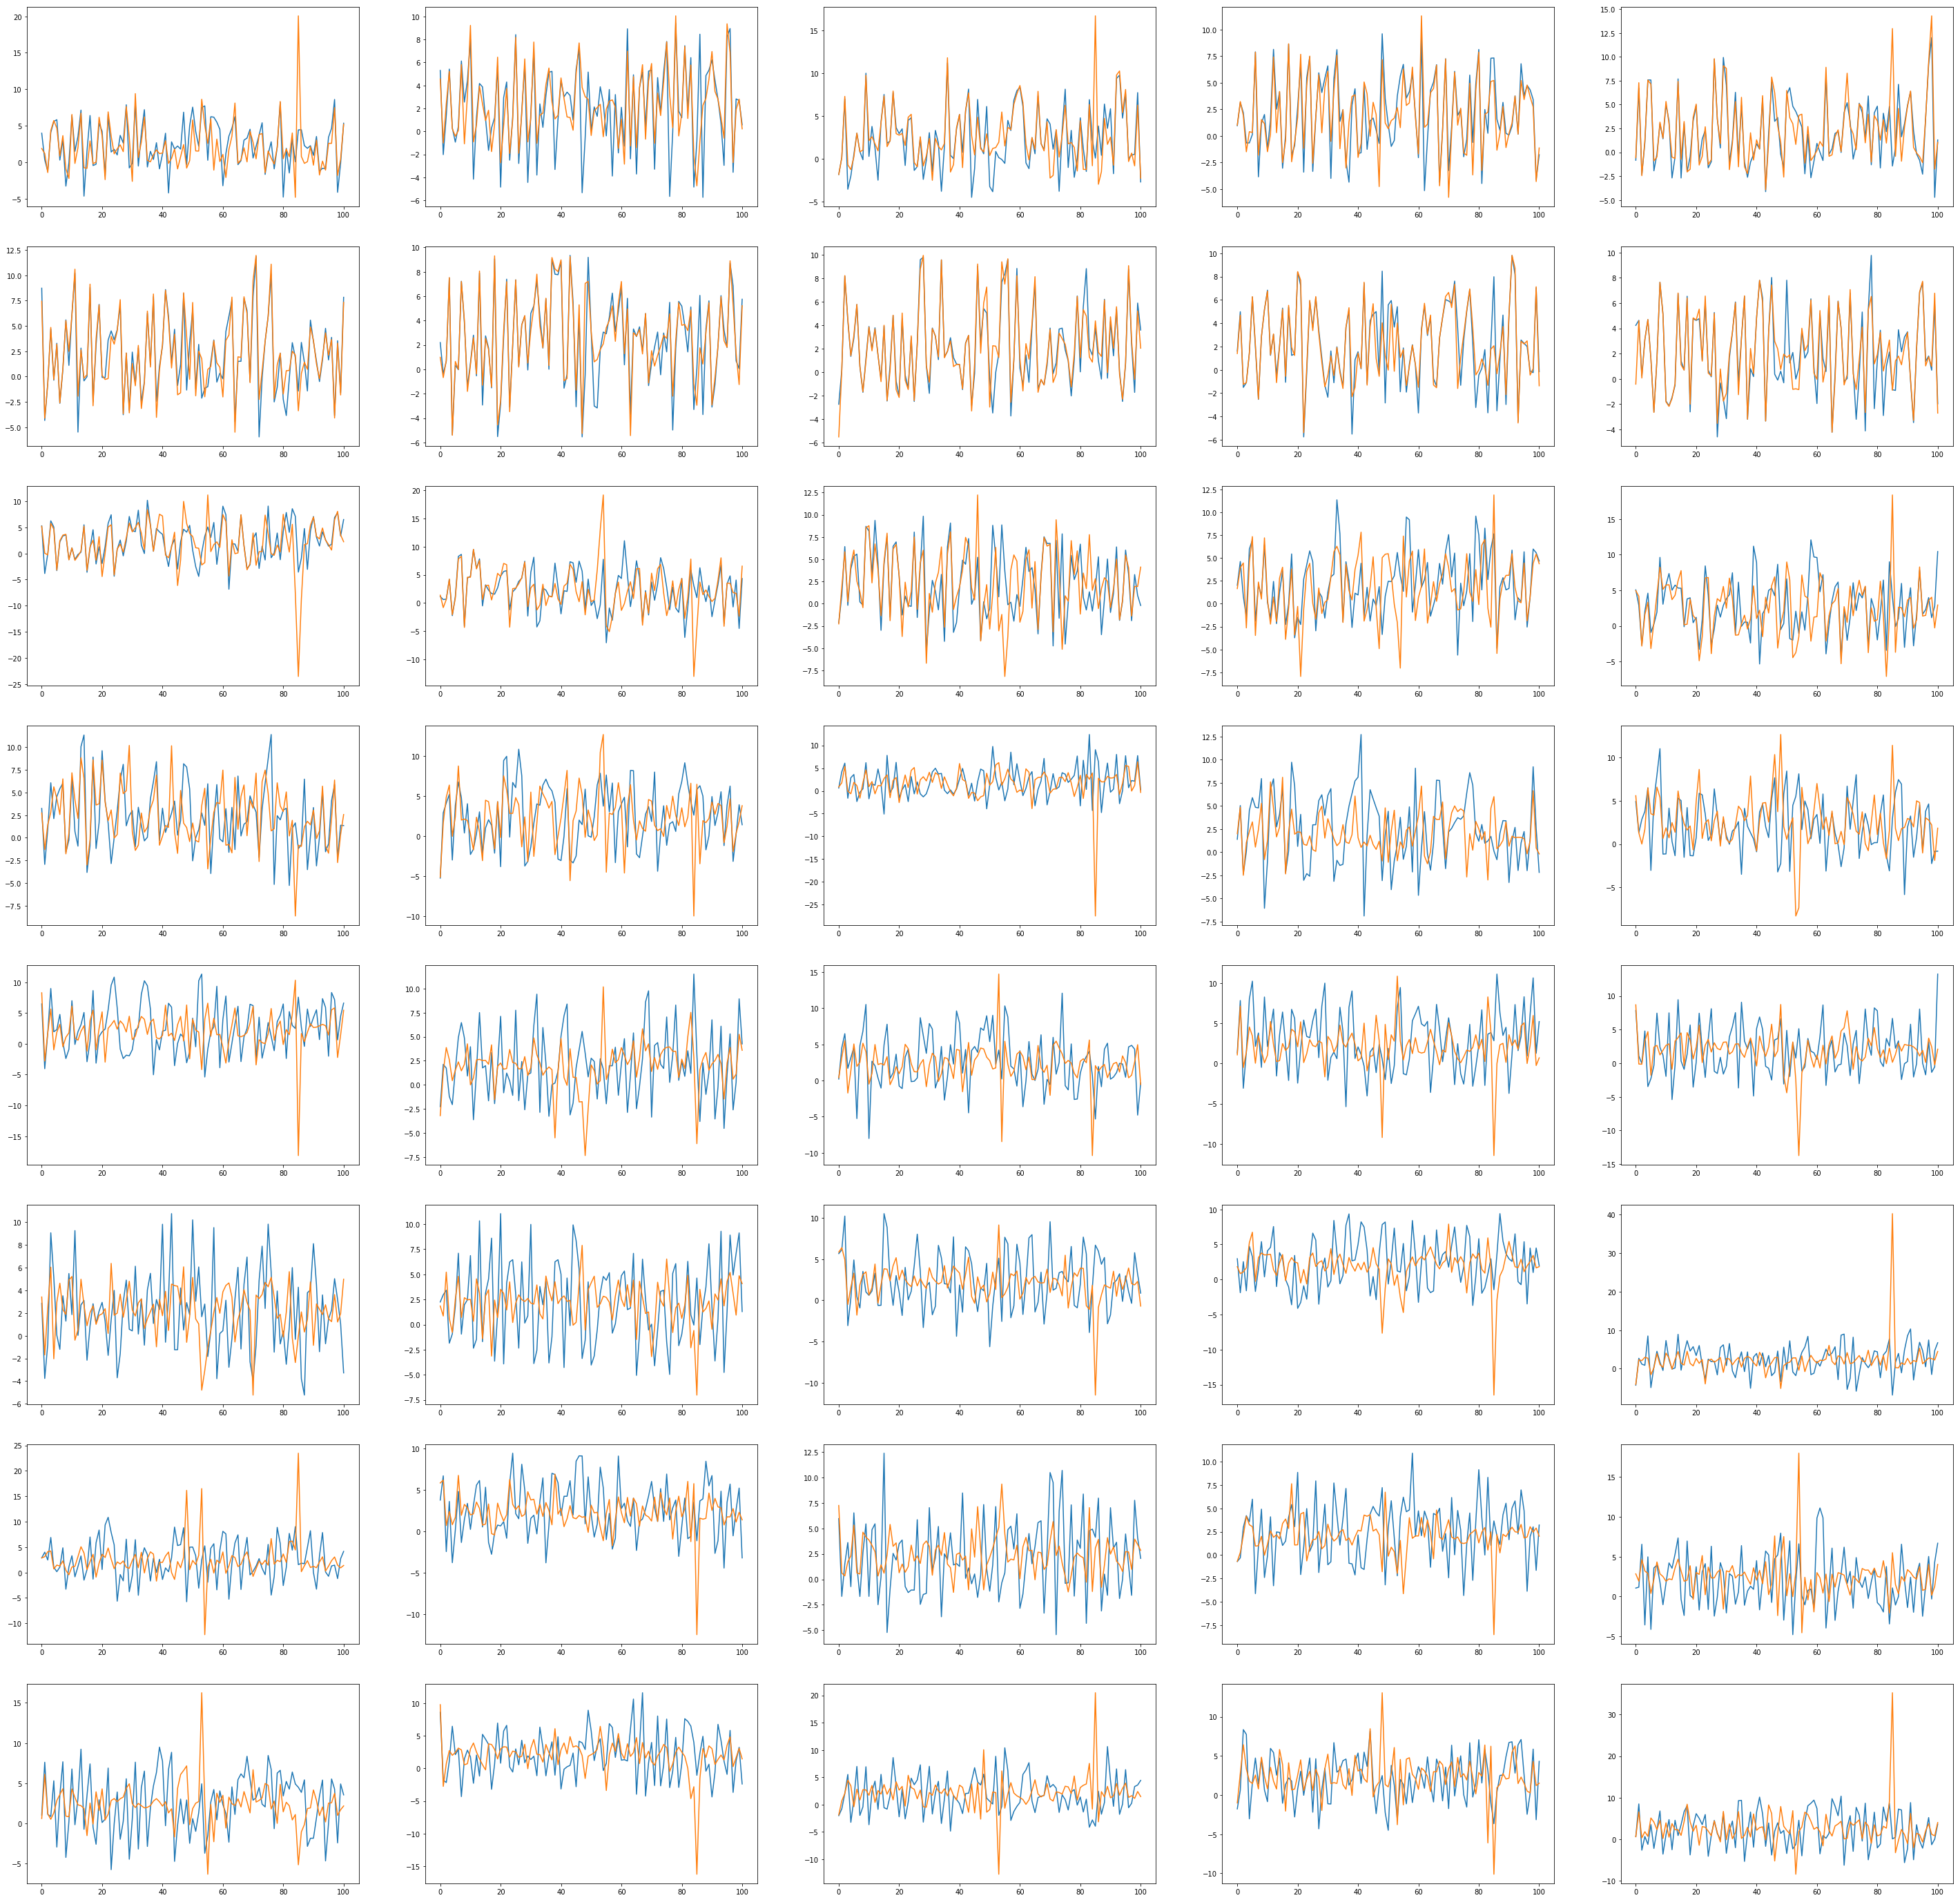

In [541]:
nsig = 2
nobs = 100

erflag = False

f,axes = plt.subplots(8,5,figsize=[50,50])
for pi in range(8):
    for pj in range(5):
        ax = axes[pi][pj]
        pk = pi * 5 + pj
        lt, = ax.plot(truestate[:nobs+1,pk])
        la, = ax.plot(enkf.analysis_history[:nobs+1,pk])
        
        if erflag:
        
            erra = np.sqrt(enkf.analysis_covariance_history[:nobs+1,pk,pk])* nsig
            ax.fill_between(range(1,nobs+1), 
                            enkf.analysis_history[1:nobs+1,pk] - erra[1:], 
                            enkf.analysis_history[1:nobs+1,pk] + erra[1:], 
                            alpha=0.5, color = la.get_color())